In [1]:
import os
import sys
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime 
windowSize=5
epochs=200
verbose=True
train=True

## Trial on my stock price data

In [2]:
#based on: https://www.youtube.com/watch?v=c0k-YLQGKjY
#format:
##         X           Y
## [[[1],[2],[3],[4]] [5]

def df_to_windowed_df(dataframe,windowSize=3):
  data=dataframe.to_numpy()
  X=[]
  Y=[]
  
  for i in range(0,len(data)-windowSize):
    # nth=[[a[0],a[1]] for a in data[i:i+windowSize]]
    nth=[[a[1]] for a in data[i:i+windowSize]]
    # print(nth)
    X.append(nth)
    Y.append((data[i+windowSize])[1])
  
  return np.array(X),np.array(Y)
    
## history of tesla share prices
filepath="TSLA.csv"
df=pd.read_csv(filepath)

df.Date = pd.to_datetime(df.Date).astype('int64') / 10**9
X,Y=df_to_windowed_df(df,windowSize=windowSize)

In [3]:
def splitDataset(X,Y,threshold=0.8,valsize=0.01): 
    #threshold means 80% is split train/val
    # valsize means 1% never sees the model in val or training; this is taken from the val side, so val is actually size = 1-threshold-valsize
    threshold_index=round(X.shape[0]*(threshold+valsize))
    valindex=round(X.shape[0]*(1-valsize))
    
    x_train=X[:threshold_index]
    y_train=Y[:threshold_index]
    
    x_val=X[threshold_index:valindex]
    y_val=Y[threshold_index:valindex]
    
    x_test=X[valindex:]
    y_test=Y[valindex:]
    
    return x_train,y_train,x_val,y_val,x_test,y_test

x_train_0,y_train_0,x_val_0,y_val_0,x_test_0,y_test_0=splitDataset(X,Y)

In [4]:
###Normalize the data!

def zscoreNorm_manual(inp,mean,std):
    return (inp-mean)/std

normalize=True
if normalize==True:
    # Order=2 makes it a minmax scaling operation (so that we can de-normalize later)
    # x_train=tf.keras.utils.normalize(x_train_0,axis=0,order=2)
    # y_train=tf.keras.utils.normalize(y_train_0,axis=0,order=2)

    # x_val=tf.keras.utils.normalize(x_val_0,axis=0,order=2)
    # y_val=tf.keras.utils.normalize(y_val_0,axis=0,order=2)

    # x_test=tf.keras.utils.normalize(x_test_0,axis=0,order=np.inf)
    # y_test=tf.keras.utils.normalize(y_test_0,axis=0,order=np.inf)
    
    unNormData={"xtrain":[np.mean(x_train_0,axis=0),np.std(x_train_0,axis=0)],"ytrain":[np.mean(y_train_0,axis=0),np.std(y_train_0,axis=0)],
                "xval":[np.mean(x_val_0,axis=0),np.std(x_val_0,axis=0)],"yval":[np.mean(y_val_0,axis=0),np.std(y_val_0,axis=0)],
                "xtest":[np.mean(x_test_0,axis=0),np.std(x_test_0,axis=0)],"ytest":[np.mean(y_test_0,axis=0),np.std(y_test_0,axis=0)]
                }
    
    
    x_train=zscoreNorm_manual(x_train_0,unNormData["xtrain"][0],unNormData["xtrain"][1])
    y_train=zscoreNorm_manual(y_train_0,unNormData["ytrain"][0],unNormData["ytrain"][1])
    
    x_val=zscoreNorm_manual(x_val_0,unNormData["xval"][0],unNormData["xval"][1])
    y_val=zscoreNorm_manual(y_val_0,unNormData["yval"][0],unNormData["yval"][1])
    
    x_test=zscoreNorm_manual(x_test_0,unNormData["xtest"][0],unNormData["xtest"][1])
    y_test=zscoreNorm_manual(y_test_0,unNormData["ytest"][0],unNormData["ytest"][1])



# OPTED TO DO MANUAL Z-SCALING NORMALIZATION HERE SO THAT I CAN REVERSE IT LATER ON;
# EVEN READING THE DOCS ON THE TF KERAS NORMALIZATION ABOVE IT SEEMED LIKE IT SHOULDVE BEEN WORKING
# BUT I COUDLNT REVERSE IT; SOMETHING WEIRD WAS GOING ON.

In [5]:
# THIS IS JUST TO VALIDATE THAT THE NORMALIZATION AND DENORMALIZATION PROCESS WORKS
if verbose:
    print(y_test_0[-4])
    print("mean",unNormData['ytest'][0],np.mean(y_test_0,axis=0))
    print("std",unNormData['ytest'][1],np.std(y_test_0,axis=0))
    print(y_test[-4])
    print(y_test[-4]*unNormData['ytest'][1]+unNormData['ytest'][0])

242.740005
mean 229.48294005882352 229.48294005882352
std 12.962013469213561 12.962013469213561
1.02276278084911
242.740005


In [6]:
if verbose:
    print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
model=tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer((x_train.shape[1],x_train.shape[2])))
model.add(tf.keras.layers.LSTM(256,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(64,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(16,'relu'))
model.add(tf.keras.layers.Dense(1,'linear'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             33024     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                5

In [8]:
logspath=os.path.join('logs','model_init')
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(logspath,'training.log'), separator=',', append=False)
cp=tf.keras.callbacks.ModelCheckpoint(logspath,save_best_only=True)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

In [9]:
if train:
    #putting this here so we can blindly run the whole script and still get the plots without HAVING to train
    # each time. Bc we still access the 'model' via a load model command below.
    history=model.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),callbacks=[cp,csv_logger],verbose=verbose)

Epoch 1/200
85/86 [============================>.] - ETA: 0s - loss: 0.2147

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 17s 139ms/step - loss: 0.2131 - val_loss: 0.2237
Epoch 2/200
83/86 [===========================>..] - ETA: 0s - loss: 0.0230

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 130ms/step - loss: 0.0226 - val_loss: 0.1339
Epoch 3/200
86/86 [==============================] - ETA: 0s - loss: 0.0200

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 129ms/step - loss: 0.0200 - val_loss: 0.1334
Epoch 4/200
83/86 [===========================>..] - ETA: 0s - loss: 0.0172

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 126ms/step - loss: 0.0169 - val_loss: 0.1105
Epoch 5/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0183 - val_loss: 0.1236
Epoch 6/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0167 - val_loss: 0.1283
Epoch 7/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0217 - val_loss: 0.1215
Epoch 8/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0173 - val_loss: 0.1214
Epoch 9/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0197 - val_loss: 0.1203
Epoch 10/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0170 - val_loss: 0.1243
Epoch 11/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0163 - val_loss: 0.1266
Epoch 12/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0139 - val_loss: 0.1337
Epoch 13/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0146 - val_loss: 0.1288
Epoch 

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 122ms/step - loss: 0.0144 - val_loss: 0.1043
Epoch 34/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0099 - val_loss: 0.1056
Epoch 35/200
83/86 [===========================>..] - ETA: 0s - loss: 0.0107

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 125ms/step - loss: 0.0107 - val_loss: 0.1042
Epoch 36/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0113 - val_loss: 0.1091
Epoch 37/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0117 - val_loss: 0.1105
Epoch 38/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0158 - val_loss: 0.1140
Epoch 39/200
84/86 [============================>.] - ETA: 0s - loss: 0.0114

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 12s 135ms/step - loss: 0.0113 - val_loss: 0.0996
Epoch 40/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0124 - val_loss: 0.1161
Epoch 41/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0101 - val_loss: 0.1004
Epoch 42/200
86/86 [==============================] - 1s 11ms/step - loss: 0.0095 - val_loss: 0.1013
Epoch 43/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0129 - val_loss: 0.1084
Epoch 44/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0116 - val_loss: 0.1108
Epoch 45/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0127 - val_loss: 0.1033
Epoch 46/200
85/86 [============================>.] - ETA: 0s - loss: 0.0145

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 123ms/step - loss: 0.0144 - val_loss: 0.0952
Epoch 47/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0122 - val_loss: 0.1016
Epoch 48/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0110 - val_loss: 0.0988
Epoch 49/200
82/86 [===========================>..] - ETA: 0s - loss: 0.0098

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 128ms/step - loss: 0.0103 - val_loss: 0.0919
Epoch 50/200
85/86 [============================>.] - ETA: 0s - loss: 0.0104

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 128ms/step - loss: 0.0105 - val_loss: 0.0861
Epoch 51/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0102 - val_loss: 0.0872
Epoch 52/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0098 - val_loss: 0.0891
Epoch 53/200
82/86 [===========================>..] - ETA: 0s - loss: 0.0098

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 126ms/step - loss: 0.0100 - val_loss: 0.0803
Epoch 54/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0102 - val_loss: 0.0839
Epoch 55/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0097 - val_loss: 0.0918
Epoch 56/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0114 - val_loss: 0.0853
Epoch 57/200
84/86 [============================>.] - ETA: 0s - loss: 0.0108

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 130ms/step - loss: 0.0107 - val_loss: 0.0789
Epoch 58/200
85/86 [============================>.] - ETA: 0s - loss: 0.0091

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 134ms/step - loss: 0.0091 - val_loss: 0.0733
Epoch 59/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0122 - val_loss: 0.0756
Epoch 60/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0110 - val_loss: 0.0735
Epoch 61/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0125 - val_loss: 0.0835
Epoch 62/200
85/86 [============================>.] - ETA: 0s - loss: 0.0106

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 124ms/step - loss: 0.0105 - val_loss: 0.0733
Epoch 63/200
84/86 [============================>.] - ETA: 0s - loss: 0.0099

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 127ms/step - loss: 0.0097 - val_loss: 0.0686
Epoch 64/200
83/86 [===========================>..] - ETA: 0s - loss: 0.0097

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 131ms/step - loss: 0.0098 - val_loss: 0.0685
Epoch 65/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0097 - val_loss: 0.0695
Epoch 66/200
86/86 [==============================] - ETA: 0s - loss: 0.0097

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 127ms/step - loss: 0.0097 - val_loss: 0.0677
Epoch 67/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0090 - val_loss: 0.0685
Epoch 68/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0112 - val_loss: 0.0680
Epoch 69/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0096 - val_loss: 0.0704
Epoch 70/200
85/86 [============================>.] - ETA: 0s - loss: 0.0103

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 128ms/step - loss: 0.0102 - val_loss: 0.0610
Epoch 71/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0075 - val_loss: 0.0648
Epoch 72/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0095 - val_loss: 0.0639
Epoch 73/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0087 - val_loss: 0.0654
Epoch 74/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0110 - val_loss: 0.0623
Epoch 75/200
82/86 [===========================>..] - ETA: 0s - loss: 0.0113

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 129ms/step - loss: 0.0110 - val_loss: 0.0605
Epoch 76/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0075 - val_loss: 0.0626
Epoch 77/200
86/86 [==============================] - ETA: 0s - loss: 0.0107

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 123ms/step - loss: 0.0107 - val_loss: 0.0529
Epoch 78/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0096 - val_loss: 0.0621
Epoch 79/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0087 - val_loss: 0.0570
Epoch 80/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0090 - val_loss: 0.0622
Epoch 81/200
84/86 [============================>.] - ETA: 0s - loss: 0.0088

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 127ms/step - loss: 0.0089 - val_loss: 0.0524
Epoch 82/200
84/86 [============================>.] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 12s 140ms/step - loss: 0.0094 - val_loss: 0.0515
Epoch 83/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0079 - val_loss: 0.0543
Epoch 84/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0089 - val_loss: 0.0517
Epoch 85/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0528
Epoch 86/200
82/86 [===========================>..] - ETA: 0s - loss: 0.0088

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 124ms/step - loss: 0.0087 - val_loss: 0.0463
Epoch 87/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0088 - val_loss: 0.0516
Epoch 88/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0088 - val_loss: 0.0516
Epoch 89/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0084 - val_loss: 0.0527
Epoch 90/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0081 - val_loss: 0.0647
Epoch 91/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0084 - val_loss: 0.0554
Epoch 92/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0086 - val_loss: 0.0498
Epoch 93/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0079 - val_loss: 0.0468
Epoch 94/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0087 - val_loss: 0.0483
Epoch 95/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0084 - val_loss: 0.0465
E

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 125ms/step - loss: 0.0098 - val_loss: 0.0456
Epoch 98/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0084 - val_loss: 0.0505
Epoch 99/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0085 - val_loss: 0.0473
Epoch 100/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0079 - val_loss: 0.0474
Epoch 101/200
84/86 [============================>.] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 126ms/step - loss: 0.0078 - val_loss: 0.0423
Epoch 102/200
85/86 [============================>.] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 129ms/step - loss: 0.0078 - val_loss: 0.0423
Epoch 103/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0078 - val_loss: 0.0472
Epoch 104/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0077 - val_loss: 0.0502
Epoch 105/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0109 - val_loss: 0.0568
Epoch 106/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0080 - val_loss: 0.0450
Epoch 107/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0069 - val_loss: 0.0459
Epoch 108/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0084 - val_loss: 0.0532
Epoch 109/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0086 - val_loss: 0.0440
Epoch 110/200
82/86 [===========================>..] - ETA: 0s - loss: 0.0085

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 126ms/step - loss: 0.0083 - val_loss: 0.0356
Epoch 111/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0085 - val_loss: 0.0416
Epoch 112/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0085 - val_loss: 0.0399
Epoch 113/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0073 - val_loss: 0.0415
Epoch 114/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0068 - val_loss: 0.0418
Epoch 115/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0406
Epoch 116/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0090 - val_loss: 0.0392
Epoch 117/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0076 - val_loss: 0.0487
Epoch 118/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0095 - val_loss: 0.0458
Epoch 119/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0063 - val_loss:

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 127ms/step - loss: 0.0069 - val_loss: 0.0327
Epoch 129/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0085 - val_loss: 0.0365
Epoch 130/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0347
Epoch 131/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0061 - val_loss: 0.0359
Epoch 132/200
86/86 [==============================] - 1s 11ms/step - loss: 0.0060 - val_loss: 0.0342
Epoch 133/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0081 - val_loss: 0.0363
Epoch 134/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0077 - val_loss: 0.0359
Epoch 135/200
86/86 [==============================] - 1s 11ms/step - loss: 0.0092 - val_loss: 0.0347
Epoch 136/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0069 - val_loss: 0.0375
Epoch 137/200
86/86 [==============================] - 1s 11ms/step - loss: 0.0086 - val_loss:

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 10s 123ms/step - loss: 0.0067 - val_loss: 0.0327
Epoch 149/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0072 - val_loss: 0.0381
Epoch 150/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0077 - val_loss: 0.0367
Epoch 151/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0063 - val_loss: 0.0341
Epoch 152/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0058 - val_loss: 0.0346
Epoch 153/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0071 - val_loss: 0.0344
Epoch 154/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0064 - val_loss: 0.0352
Epoch 155/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0081 - val_loss: 0.0484
Epoch 156/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0330
Epoch 157/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0064 - val_loss:

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 132ms/step - loss: 0.0050 - val_loss: 0.0326
Epoch 160/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0075 - val_loss: 0.0382
Epoch 161/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.0332
Epoch 162/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0328
Epoch 163/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0058 - val_loss: 0.0342
Epoch 164/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0071 - val_loss: 0.0348
Epoch 165/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0073 - val_loss: 0.0334
Epoch 166/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0075 - val_loss: 0.0330
Epoch 167/200
84/86 [============================>.] - ETA: 0s - loss: 0.0056

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 128ms/step - loss: 0.0057 - val_loss: 0.0326
Epoch 168/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0328
Epoch 169/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0063 - val_loss: 0.0342
Epoch 170/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0071 - val_loss: 0.0331
Epoch 171/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0059 - val_loss: 0.0412
Epoch 172/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0067 - val_loss: 0.0336
Epoch 173/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0065 - val_loss: 0.0401
Epoch 174/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0065 - val_loss: 0.0390
Epoch 175/200
86/86 [==============================] - 1s 12ms/step - loss: 0.0066 - val_loss: 0.0361
Epoch 176/200
86/86 [==============================] - 1s 13ms/step - loss: 0.0051 - val_loss:

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 11s 130ms/step - loss: 0.0059 - val_loss: 0.0302
Epoch 180/200
86/86 [==============================] - 1s 16ms/step - loss: 0.0060 - val_loss: 0.0323
Epoch 181/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0067 - val_loss: 0.0326
Epoch 182/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0058 - val_loss: 0.0316
Epoch 183/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0067 - val_loss: 0.0369
Epoch 184/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0052 - val_loss: 0.0409
Epoch 185/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0063 - val_loss: 0.0366
Epoch 186/200
86/86 [==============================] - 1s 15ms/step - loss: 0.0057 - val_loss: 0.0359
Epoch 187/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0065 - val_loss: 0.0373
Epoch 188/200
86/86 [==============================] - 1s 14ms/step - loss: 0.0073 - val_loss:

In [10]:
# this is just making sure we can access it
model=tf.keras.models.load_model(logspath)
log_data = pd.read_csv(os.path.join(logspath,'training.log'), sep=',', engine='python') #this loads up the history

In [11]:
train_predictions=model.predict(x_train).flatten()
yflat=y_train.flatten()

86/86 [==============================] - 1s 5ms/step


In [12]:
train_predictions=model.predict(x_train).flatten()
train_results=pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals':yflat})

if verbose:
    train_results

86/86 [==============================] - 0s 4ms/step


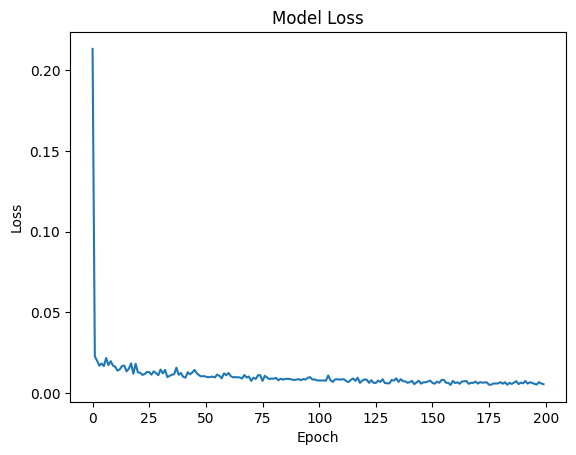

In [13]:
## Check for overfitting
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [14]:
## evaluate the model
testscore=model.evaluate(x_test,y_test)
if verbose: 
    print(testscore)

2/2 [==============================] - 1s 5ms/step - loss: 0.2969
0.2969304621219635


In [15]:
# Add dates here because we arent training with the date becasue that is kind of annoying to do.
def genDateSplit(dates,windowSize,threshold=0.8,valsize=0.01): 
    #threshold means 80% is split train/val
    # valsize means 1% never sees the model in val or training; this is taken from the val side, so val is actually size = 1-threshold-valsize
    threshold_index=round(X.shape[0]*(threshold+valsize))+windowSize
    valindex=round(X.shape[0]*(1-valsize))+windowSize
    
    a=dates[windowSize:threshold_index]
    b=dates[threshold_index:valindex]
    c=dates[valindex:]
    
    print(len(a),len(b),len(c))
    
    return a,b,c

unixdates=df.Date.tolist()
ndates=[]
for i in unixdates:
    ndates.append(datetime.datetime.utcfromtimestamp(i).strftime('%Y-%m-%d'))
# print(ndates)

trainDates,val_dates,testDates=genDateSplit(ndates,windowSize)


2742 609 34


In [16]:
if verbose:
    # compare lengths of the data things
    print("train", len(trainDates),y_train.shape[0])
    print("val", len(val_dates),y_val.shape[0])
    print("test", len(testDates),y_test.shape[0])

train 2742 2742
val 609 609
test 34 34


In [17]:
new_x_set4Predict=np.concatenate((x_test[-1:,-9:,:],np.array([[y_test[-1]]]).reshape(1, 1, 1)),axis=1)

val_predictions=model.predict(x_val)
test_predictions=model.predict(x_test)
future_predict=model.predict(new_x_set4Predict)

1/1 [==============================] - 1s 985ms/step


In [18]:
## un-normalize data so that we can have the context to it
def unNormalize(normddata,meann,stddev):
    # print(meann,stddev)
    orig=normddata*stddev + meann
    return orig

normed_ytrain=unNormalize(y_train,unNormData['ytrain'][0],unNormData['ytrain'][1])
normed_yval=unNormalize(y_val,unNormData['yval'][0],unNormData['yval'][1])
normed_ytest=unNormalize(y_test,unNormData['ytest'][0],unNormData['ytest'][1])

normValPreedict=unNormalize(val_predictions,unNormData['yval'][0],unNormData['yval'][1])
normTestPredictions=unNormalize(test_predictions,unNormData['ytest'][0],unNormData['ytest'][1])
normed_futurePrediction=unNormalize(future_predict,unNormData['ytest'][0],unNormData['ytest'][1])


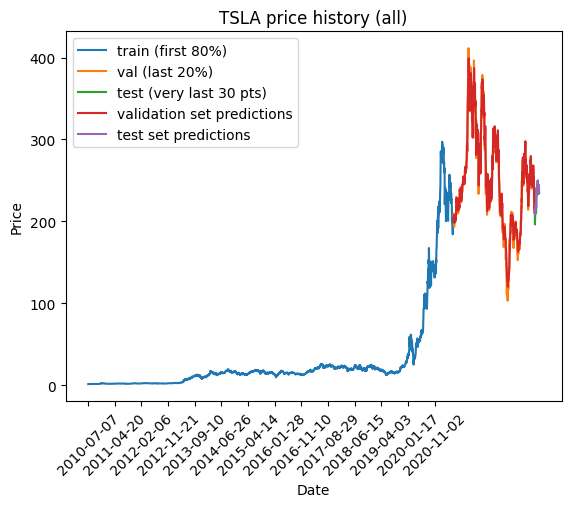

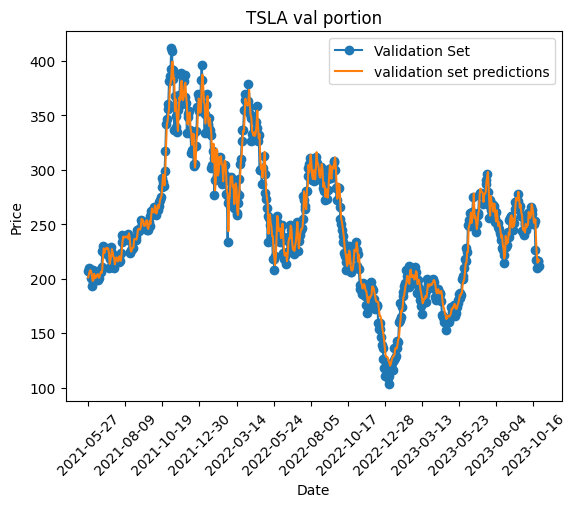

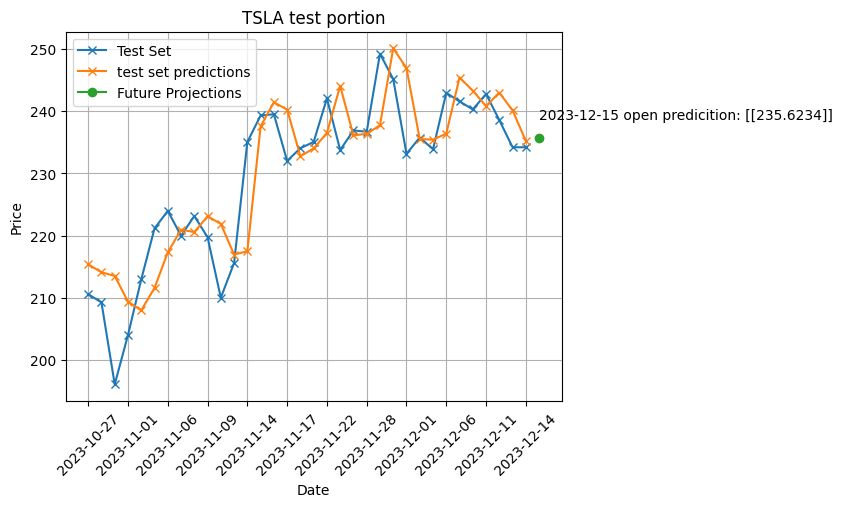

IT LOOKS LIKE THERE IS A ONE STEP OFFSET HERE, WHEN YOU ZOOM IN, BUT THERE ISNT, THE MODEL JUST SUCKS


In [19]:
#Plot the real stock prices
plt.plot(trainDates,normed_ytrain.flatten(),label="train (first 80%)")
plt.xticks(trainDates[::200],rotation=45)
plt.plot(val_dates,normed_yval.flatten(),label="val (last 20%)")
plt.plot(testDates,normed_ytest.flatten(),label="test (very last 30 pts)")

plt.plot(val_dates,normValPreedict,label="validation set predictions")
plt.plot(testDates,normTestPredictions,label="test set predictions")
plt.title('TSLA price history (all)')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

plt.plot(val_dates,normed_yval,label="Validation Set",marker='o')

plt.plot(val_dates,normValPreedict,label="validation set predictions")
plt.xticks(val_dates[::50],rotation=45)
plt.title('TSLA val portion')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

plt.plot(testDates,normed_ytest,label="Test Set",marker='x')
plt.plot(testDates,normTestPredictions,label="test set predictions",marker='x')
futureDate=(datetime.datetime.strptime(testDates[-1],'%Y-%m-%d')+datetime.timedelta(days=1)).strftime('%Y-%m-%d')
plt.plot(futureDate,normed_futurePrediction,label="Future Projections",marker='o')
plt.annotate(f"{futureDate} open predicition: {normed_futurePrediction}",[futureDate,normed_futurePrediction+3])
plt.xticks(testDates[::3],rotation=45)
plt.title('TSLA test portion')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid()
plt.legend() 
plt.show()

print('IT LOOKS LIKE THERE IS A ONE STEP OFFSET HERE, WHEN YOU ZOOM IN, BUT THERE ISNT, THE MODEL JUST SUCKS')
